In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.callbacks import TensorBoard
import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import numpy as np

In [2]:
# Configuration TensorBoard
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)







In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv('db/questions_db.csv')
print(df.head)
# pour réduire l'échantillon si nécessaire
df = df.sample(frac=0.1, random_state=42) 


<bound method NDFrame.head of                                                                                                   Title  \
0                               C++ function template specialization based on the templated return type   
1                                                      How can I write a std::apply on a std::expected?   
2      App must target Android 14 (API level 34) or higher is showing even after update to API level 34   
3                            Efficiently find the number of different classmates from course-level data   
4                                   Get the first and last number occuring in a (text) string in a cell   
...                                                                                                 ...   
49995                                 Remove all punctuation from string, except if it's between digits   
49996                                                                cannot resolve method 'getFont(?)'   
49997  

In [5]:
# Nettoie le texte
def clean_text(text):
    if isinstance(text, str):
        # Enlève les caractères spéciaux (y compris les balises HTML) pour ne garder que les lettres, les chiffres, et les espaces
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Converti en minuscule
        text = text.lower()
    return text


# transforme les tags sous forme de chaîne de caractères en liste
def process_tags(tags):
    if isinstance(tags, str):
        
        # Enlève les symboles '<>' entourant les tags et les divise en une liste
        return tags.strip('<>').split('><')
    else:
        return []

# Applique le traitement des tags à la colonne 'Tags' du DataFrame
df['Tags'] = df['Tags'].apply(process_tags)


# Applique clean_text pour nettoyer les colonnes 'Title' et 'Body'
df['Title'] = df['Title'].apply(clean_text)
df['Body'] = df['Body'].apply(clean_text)


print(df.head())

                                                      Title  \
33553                       convert pdf to docx with python   
9427     unknown option error from babel in reactnative app   
199                              not found for an api route   
12447                             remove emojis from string   
39489  permission denied when installing npm modules in osx   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [6]:
# Vérifie les valeurs manquantes
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne:")
    print(missing_values)
    if missing_values.any():
        print("\nColonnes avec valeurs manquantes:")
        print(missing_values[missing_values > 0])
    else:
        print("Aucune valeur manquante trouvée.")


check_missing_values(df)

Nombre de valeurs manquantes par colonne:
Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
FavoriteCount    1852
AnswerCount         0
CreationDate        0
dtype: int64

Colonnes avec valeurs manquantes:
FavoriteCount    1852
dtype: int64


Nombre total de tags extraits: 14944
['javascript', 'python', 'android', 'java', 'reactjs', 'html', 'flutter', 'arrays', 'css', 'angular', 'node.js', 'c#', 'python-3.x', 'dart', 'php', 'typescript', 'ios', 'react-native', 'jquery', 'list', 'sql', 'laravel', 'visual-studio-code', 'docker', 'swift', 'c++', 'string', 'android-studio', 'firebase', 'pandas', 'json', 'c', 'npm', 'kotlin', 'spring-boot', 'vue.js', 'r', 'sql-server', 'xcode', 'regex', 'mysql', 'gradle', 'asp.net-core', 'object', 'spring', 'macos', 'git', 'amazon-web-services', 'windows', 'dictionary']


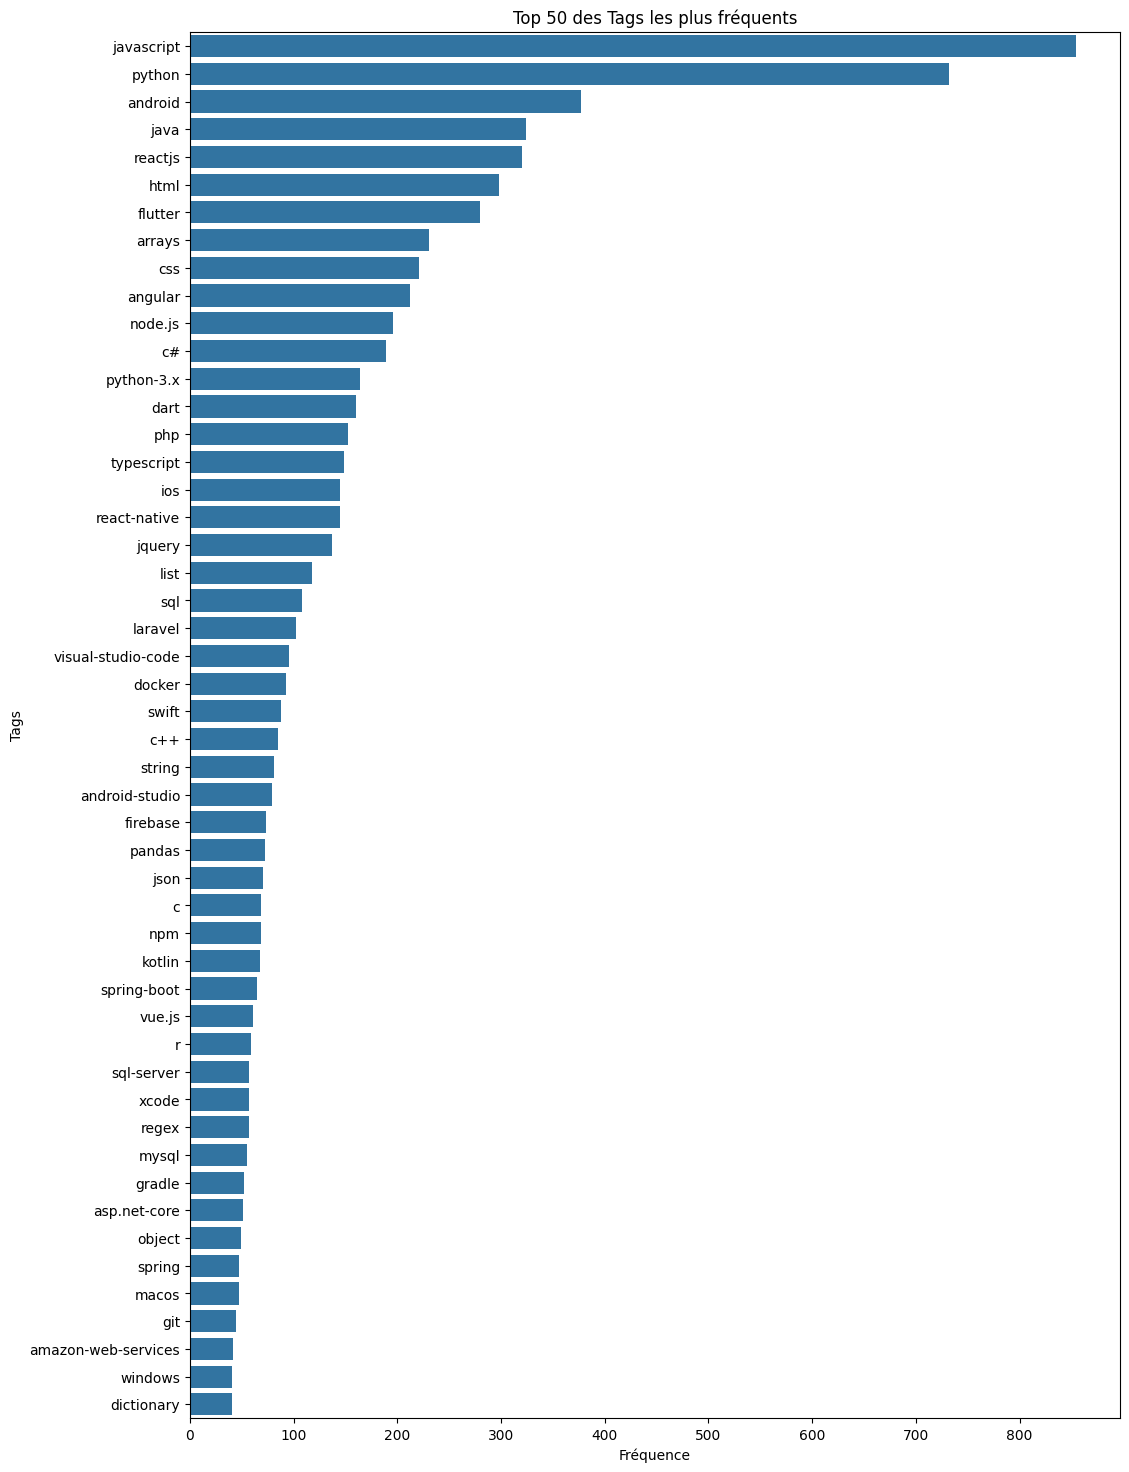

In [7]:
# Crée une liste des tags présents dans le DataFrame
all_tags = [tag for tags in df['Tags'] for tag in tags]

# Vérifie si all_tags est bien généré
if all_tags:
    # Si oui, affiche le nombre total de tags extraits
    print(f"Nombre total de tags extraits: {len(all_tags)}")
else:
    print("Erreur : Aucun tag n'a été extrait")

# Compte la fréquence de chaque tag et sélectionne les 50 tags les plus fréquents
tag_counts = pd.Series(all_tags).value_counts().head(50)

# Les convertie en une liste
top_tags = list(tag_counts.index)

# Filtre les questions pour ne conserver que celles avec les top 50 tags
df['Filtered_Tags'] = df['Tags'].apply(lambda tags: [tag for tag in tags if tag in top_tags])

# Supprime les questions sans tags dans le top 50
df = df[df['Filtered_Tags'].apply(len) > 0]

print(top_tags)
plt.figure(figsize=(12, 18))
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 50 des Tags les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Tags')
plt.show()

In [8]:
# vérifie la présence de balises HTML et de caractères spéciaux dans un texte
def check_html_special_chars(text):
    if isinstance(text, str):
        # Trouve toutes les balises HTML dans le texte
        html_tags = re.findall(r'<.*?>', text)
        # Trouve tous les caractères spéciaux (non alphanumériques et non espaces) 
        special_chars = re.findall(r'[^a-zA-Z0-9\s]', text)
        # Retourne le nombre total de balises HTML et de caractères spéciaux trouvés
        return len(html_tags) + len(special_chars)
    return 0


# Applique check_html_special_chars à la colonne 'Title'
df['Title_html_special'] = df['Title'].apply(check_html_special_chars)
# Applique check_html_special_chars à la colonne 'Body'

df['Body_html_special'] = df['Body'].apply(check_html_special_chars)

print("Occurrences de caractères HTML ou spéciaux restants dans les titres")
print(df['Title_html_special'].value_counts())
print("Occurrences de caractères HTML ou spéciaux restants dans les corps")
print(df['Body_html_special'].value_counts())

# Vérification des tags
print("Vérification des tags")
print(df['Tags'].head(10))

# Affiche le tableau complet sans limite
print(df)

Occurrences de caractères HTML ou spéciaux restants dans les titres
Title_html_special
0    4419
Name: count, dtype: int64
Occurrences de caractères HTML ou spéciaux restants dans les corps
Body_html_special
0    4419
Name: count, dtype: int64
Vérification des tags
33553                             [python, pdf, docx, libreoffice, doc]
9427     [javascript, typescript, react-native, babeljs, metro-bundler]
199                                               [javascript, next.js]
12447                                                      [php, emoji]
39489                                             [node.js, macos, npm]
42724                        [android, singleton, kotlin, android-room]
10822      [angular, typescript, internet-explorer-11, browser-support]
49498                                                [sql-server, ssis]
4144                                 [java, spring-boot, maven, lombok]
36958                        [android, autocomplete, google-places-api]
Name: Tags, dt

In [9]:
def add_features(df):
    # Longueur du titre
    df['Title_length'] = df['Title'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0)
    # Nombre de mots dans le corps
    df['Body_word_count'] = df['Body'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else 0)
    # Nombre de tags
    df['Tag_count'] = df['Tags'].apply(
        lambda x: len(x) if isinstance(x, list) else 0)
    return df


# Ajoute les features supplémentaires
df = add_features(df)
print(df.head(10))

                                                                                                Title  \
33553                                                                 convert pdf to docx with python   
9427                                               unknown option error from babel in reactnative app   
199                                                                        not found for an api route   
12447                                                                       remove emojis from string   
39489                                            permission denied when installing npm modules in osx   
42724                                                               using room as singleton in kotlin   
10822                                                       angular 9 application not running on ie11   
49498  cant create a ssisdb catalog due to missing ssisdbbackupbak file even though ssis is installed   
4144                                                   

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4419 entries, 33553 to 20382
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               4419 non-null   object 
 1   Body                4419 non-null   object 
 2   Tags                4419 non-null   object 
 3   Id                  4419 non-null   int64  
 4   Score               4419 non-null   int64  
 5   ViewCount           4419 non-null   int64  
 6   FavoriteCount       2728 non-null   float64
 7   AnswerCount         4419 non-null   int64  
 8   CreationDate        4419 non-null   object 
 9   Filtered_Tags       4419 non-null   object 
 10  Title_html_special  4419 non-null   int64  
 11  Body_html_special   4419 non-null   int64  
 12  Title_length        4419 non-null   int64  
 13  Body_word_count     4419 non-null   int64  
 14  Tag_count           4419 non-null   int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 552.4+

In [11]:
df = df.drop(columns=['FavoriteCount'])

## Analyse multivariée


In [12]:
cols_to_analyze = ['Score', 'ViewCount', 'AnswerCount',
                   'Title_length', 'Body_word_count', 'Tag_count']
score_col = 'Score'
view_col = 'ViewCount'
favorite_col = 'FavoriteCount'

Analyse Univariée


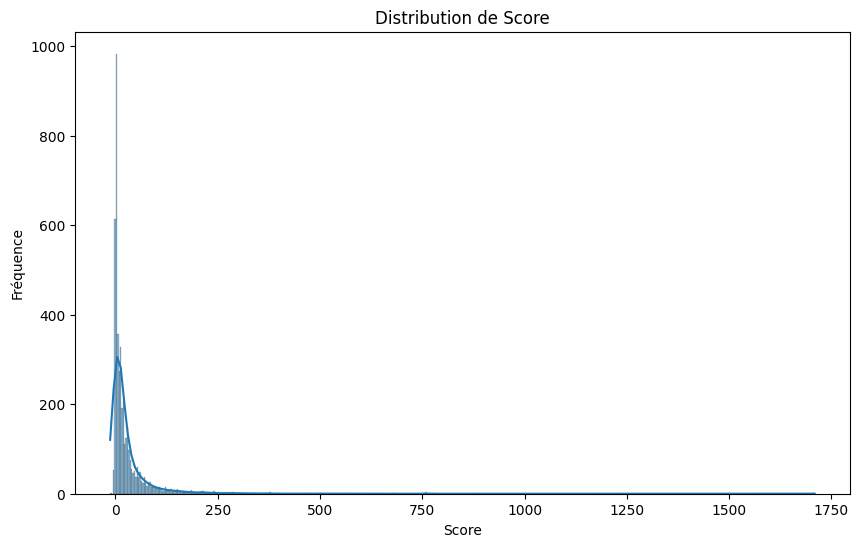

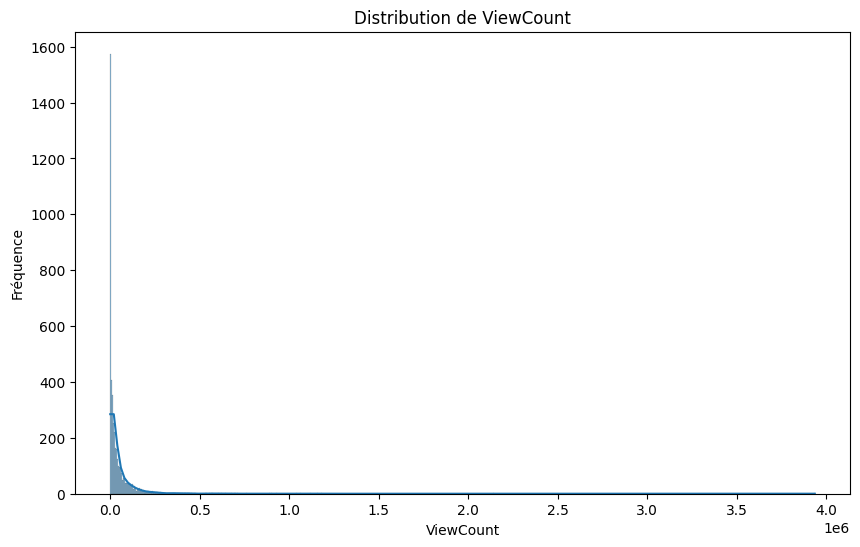

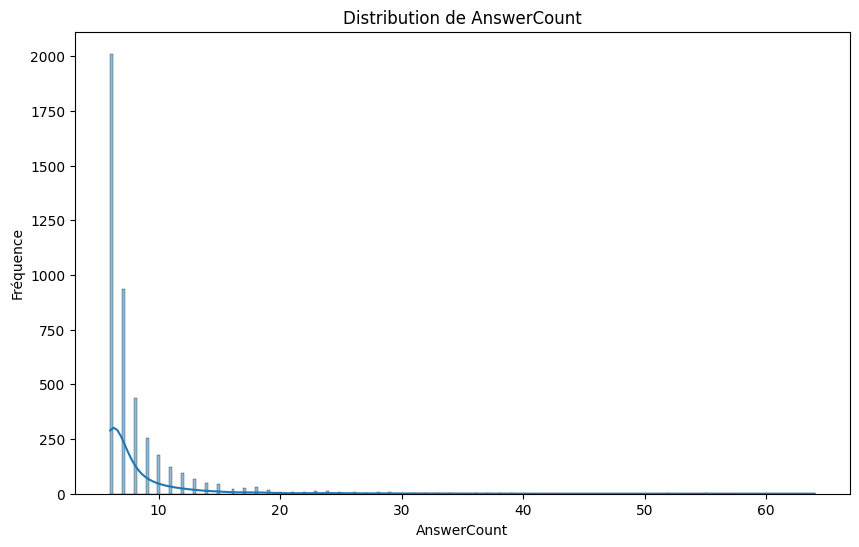

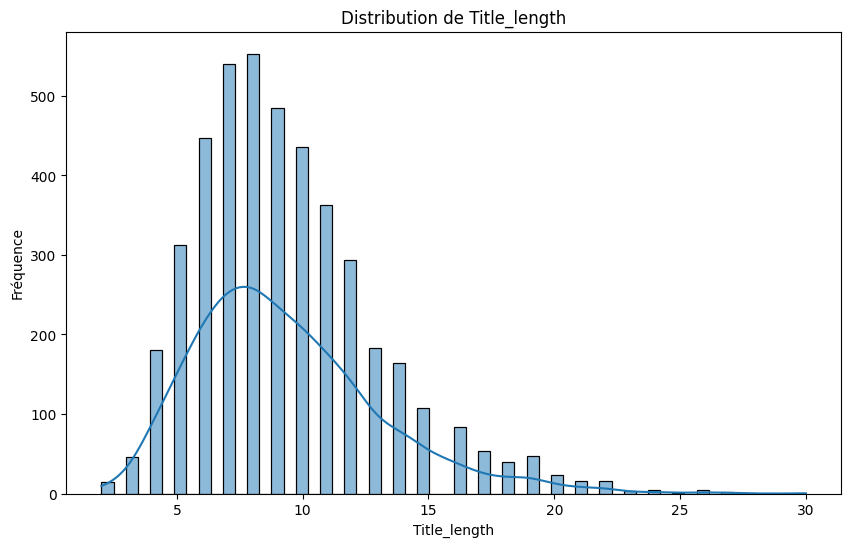

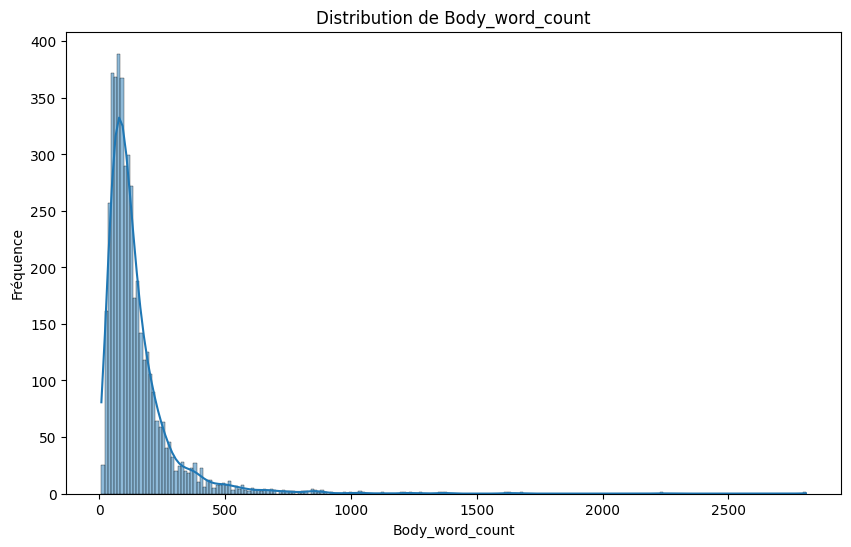

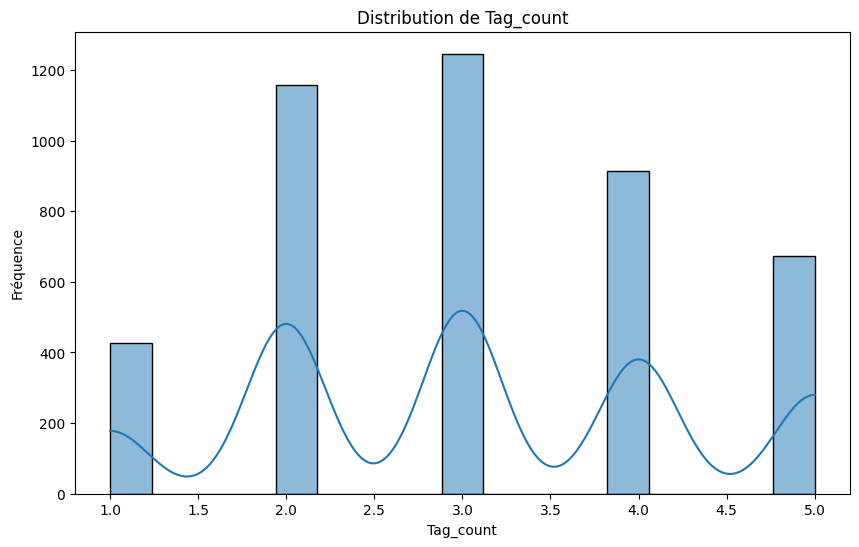

Analyse Multivariée


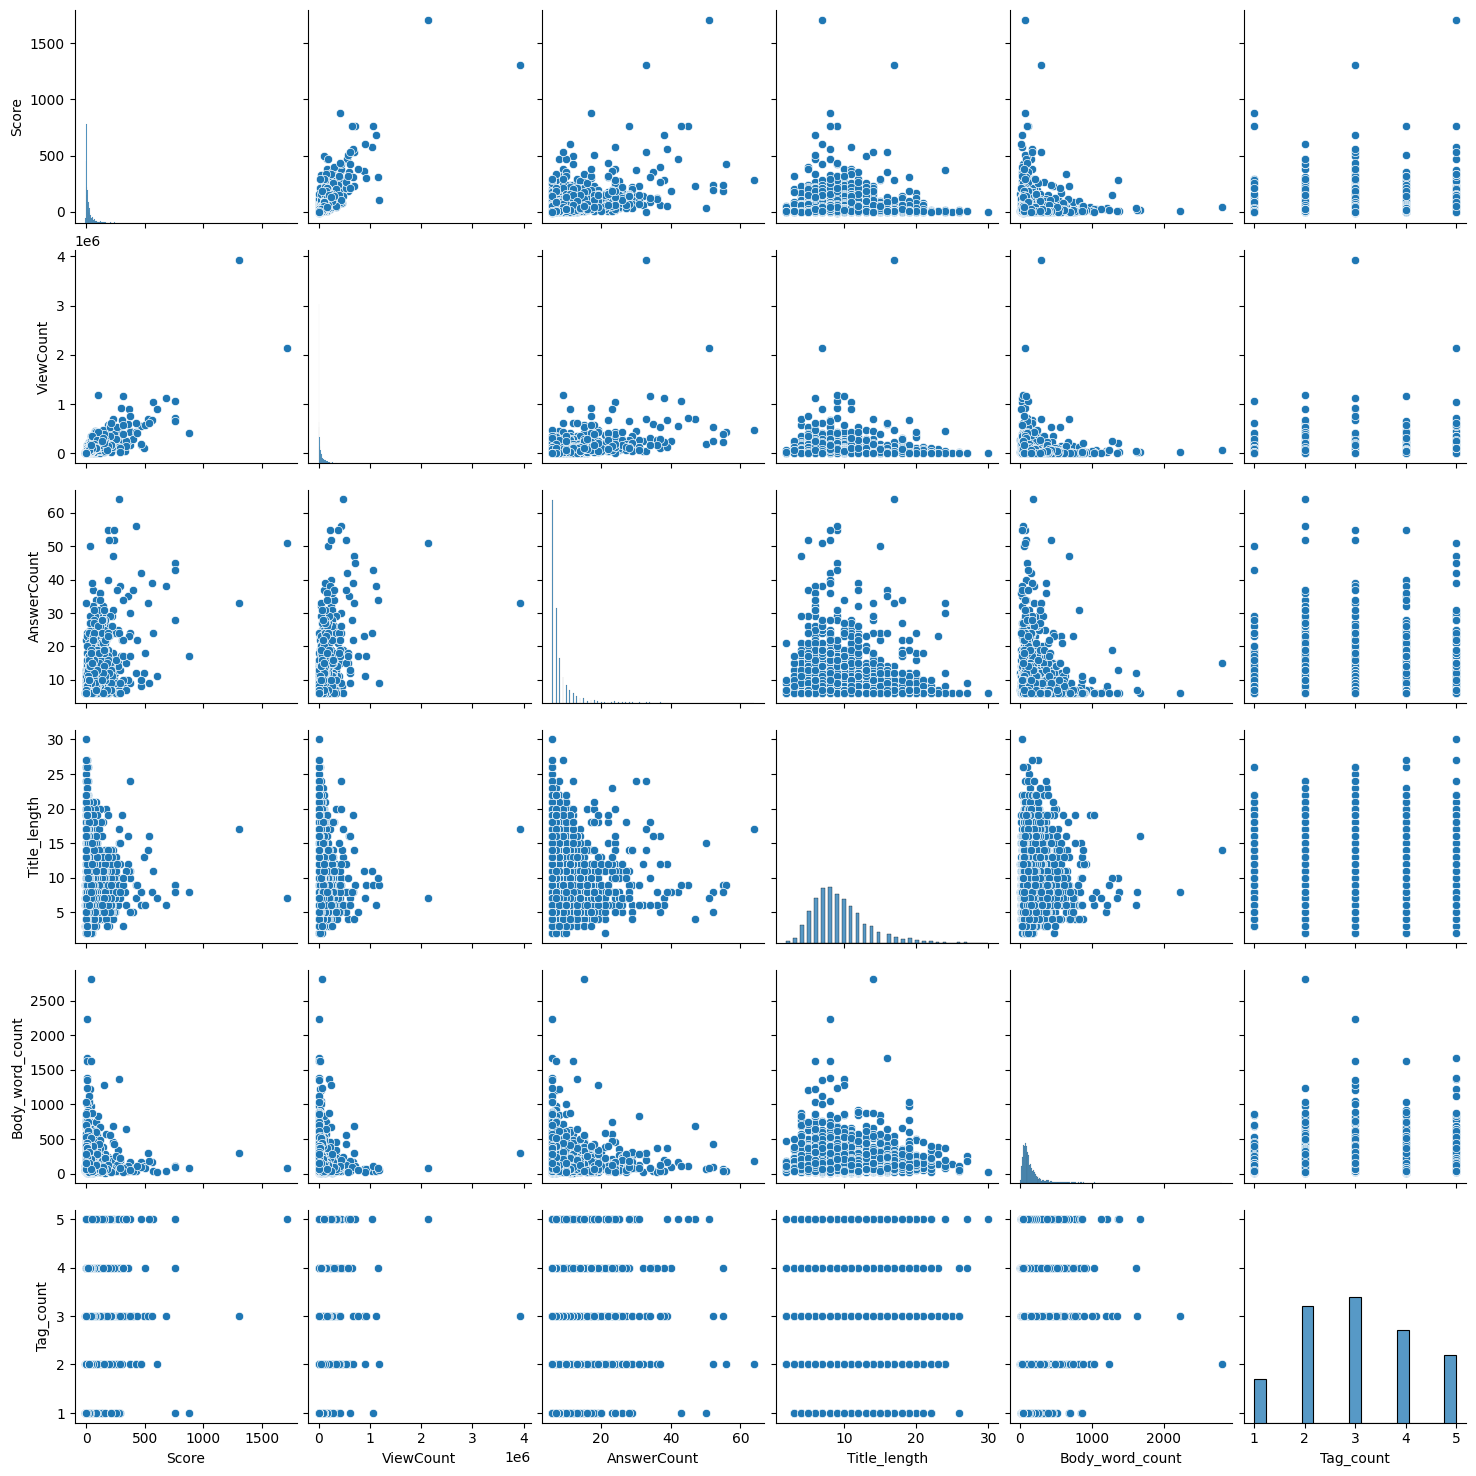

In [13]:
def analyse_univariee_multivariee(df, cols):
    print("Analyse Univariée")
    for column in cols:
        if column in df.columns:
            plt.figure(figsize=(10, 6))
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution de {column}')
            plt.xlabel(column)
            plt.ylabel('Fréquence')
            plt.show()

    print("Analyse Multivariée")
    sns.pairplot(df[cols].select_dtypes(include=['int64', 'float64']))
    plt.show()


analyse_univariee_multivariee(df, cols_to_analyze)

In [14]:
print(df.describe())

                 Id        Score     ViewCount  AnswerCount  \
count  4.419000e+03  4419.000000  4.419000e+03  4419.000000   
mean   5.533332e+07    28.731840  4.344721e+04     8.178095   
std    8.661653e+06    65.745337  1.066732e+05     4.500763   
min    4.314564e+07   -13.000000  4.100000e+01     6.000000   
25%    4.822993e+07     2.000000  1.880000e+03     6.000000   
50%    5.370686e+07    10.000000  1.446400e+04     7.000000   
75%    6.086880e+07    30.000000  4.673650e+04     8.000000   
max    7.849482e+07  1709.000000  3.936259e+06    64.000000   

       Title_html_special  Body_html_special  Title_length  Body_word_count  \
count              4419.0             4419.0   4419.000000      4419.000000   
mean                  0.0                0.0      9.335596       146.437429   
std                   0.0                0.0      3.715899       145.481683   
min                   0.0                0.0      2.000000         8.000000   
25%                   0.0            

In [15]:
def distribution_scores_vues_favoris(df, score_col, view_col, favorite_col):
    if score_col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[score_col], bins=30, kde=True)
        plt.title(f'Distribution de {score_col}')
        plt.xlabel(score_col)
        plt.ylabel('Fréquence')
        plt.show()

    if view_col in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[view_col], bins=30, kde=True)
        plt.title(f'Distribution de {view_col}')
        plt.xlabel(view_col)
        plt.ylabel('Fréquence')
        plt.show()

    if favorite_col in df.columns and df[favorite_col].notnull().sum() > 0:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[favorite_col], bins=30, kde=True)
        plt.title(f'Distribution de {favorite_col}')
        plt.xlabel(favorite_col)
        plt.ylabel('Fréquence')
        plt.show()
    else:
        print(f"La colonne {favorite_col} est vide ou n'existe pas.")

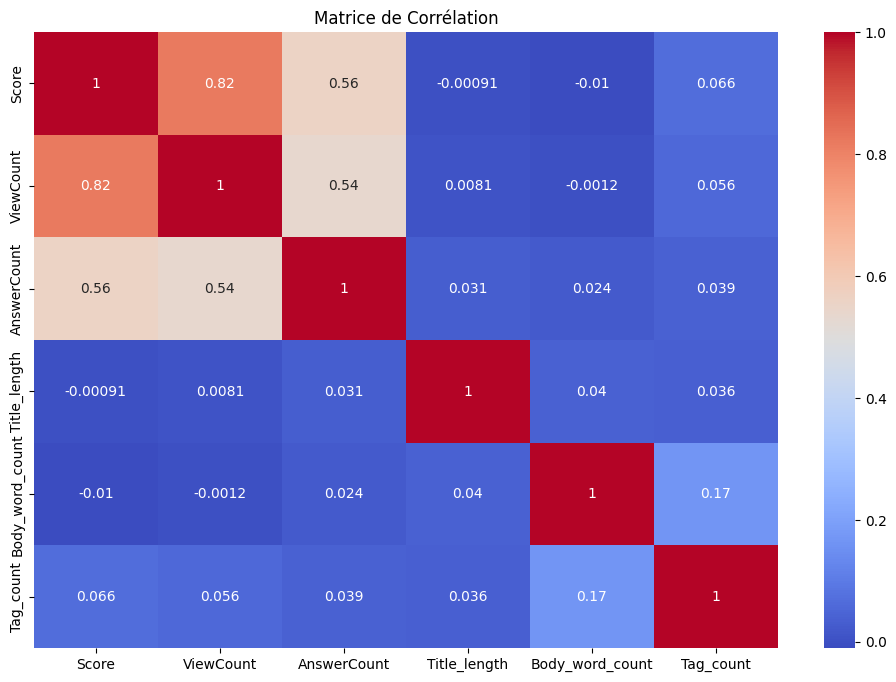

In [16]:
def correlation_variables(df, cols):
    corr_matrix = df[cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Matrice de Corrélation')
    plt.show()


correlation_variables(df, cols_to_analyze)

### Tokenization + stopwords + lemmatization

In [17]:



# Nettoie le texte des mots vides
def treatments_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Suppression des stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Colonnes Title et Body


def clean_dataframe(df):
    df['Cleaned_Title'] = df['Title'].apply(treatments_text)
    df['Cleaned_Body'] = df['Body'].apply(treatments_text)
    return df


df = clean_dataframe(df)

# Verification
print(df[['Title', 'Cleaned_Title', 'Body', 'Cleaned_Body']].head())

                                                      Title  \
33553                       convert pdf to docx with python   
9427     unknown option error from babel in reactnative app   
199                              not found for an api route   
12447                             remove emojis from string   
39489  permission denied when installing npm modules in osx   

                                     Cleaned_Title  \
33553                      convert pdf docx python   
9427    unknown option error babel reactnative app   
199                                found api route   
12447                         remove emojis string   
39489  permission denied installing npm module osx   

                                                                                                                                                                                                                                                                                                        

### Différentes méthodes pour traiter les mots

In [18]:

def transform_text_to_bow(df):
    # Bag of Words : compte les mots et les represente en format numérique 
    vectorizer = CountVectorizer(max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(df['Cleaned_Body'])

    # Réduction de dimension avec TruncatedSVD : réduit la dimensionnalité des vecteurs BoW
    svd = TruncatedSVD(n_components=100)
    X_reduced = svd.fit_transform(X)

    # Transformation des tags : convertit les tags en une forme utilisable pour l'apprentissage supervisé
    mlb = MultiLabelBinarizer(classes=top_tags)
    y = mlb.fit_transform(df['Filtered_Tags'])


    return X_reduced, y, vectorizer, svd, mlb

In [19]:
def train_word2vec(df, column='Cleaned_Body', vector_size=50, window=5, min_count=3, workers=4):
    sentences = df[column].apply(word_tokenize).tolist()
    word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    def document_vector(doc):
        doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
        return np.mean(word2vec_model.wv[doc], axis=0) if doc else np.zeros(vector_size)
    
    df['word2vec_vector'] = df[column].apply(lambda x: document_vector(word_tokenize(x)))
    
    X_word2vec = np.vstack(df['word2vec_vector'].values)
    word2vec_model.save('model/word2vec')
    return X_word2vec

X_word2vec = train_word2vec(df)

PermissionError: [Errno 13] Permission denied: 'model/'

In [ ]:
X_reduced, y, vectorizer, svd, mlb = transform_text_to_bow(df)

# Vérification que X_reduced et y ne sont pas None
print("Shape of X_reduced:", X_reduced.shape if X_reduced is not None else "X_reduced is None")
print("Shape of y:", y.shape if y is not None else "y is None")


In [ ]:
# Sauvegarde avec pickle de quelques valeurs a travailler dans un autre notebook

import pickle

# Sauvegarde des objets
with open('model/X_reduced.pkl', 'wb') as f:
    pickle.dump(X_reduced, f)

with open('model/y.pkl', 'wb') as f:
    pickle.dump(y, f)

with open('model/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model/svd.pkl', 'wb') as f:
    pickle.dump(svd, f)

with open('model/top_tags.pkl', 'wb') as f:
    pickle.dump(top_tags, f)

# Affichage de top_tags après la sauvegarde
print(top_tags)
